# COVID-19 correlated variables of Mexican Municipalities

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe was created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

It also uses the variables of dataframe obtain in the [Week 3 analyzes](Week3States.ipynb).

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican States

Read boundary polygons for Mexican states from shapefile

In [3]:
admin2_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin2.parquet'

In [4]:
resp = urlopen(admin2_url)
admin2 = gpd.read_parquet(BytesIO(resp.read()))

Converting the identifying code of municipality that belongs to a certain state

In [5]:
admin2['CVEGEO']=admin2['CVEGEO'].astype('int')

In [6]:
admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,1001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774..."
1,1002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948..."
2,1003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902..."
3,1004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248..."
4,1005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546..."


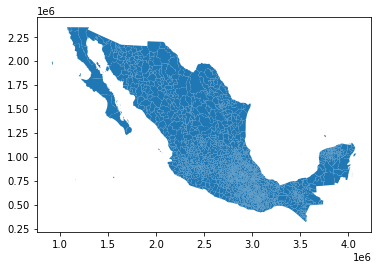

In [7]:
admin2.plot();

## Map of COVID-19 correlated variables by Municipality

Get COVID-19 correlated variables from data files

In [8]:
var_admin2 = pd.read_csv('../data/week3analyzesMunicipalities.csv')

Add CVEGEO state-municipality code column

In [9]:
var_admin2.rename(columns = {'cve_ent':'CVEGEO'},inplace=True)

In [10]:
var_admin2.head()

,CVEGEO,case_rate,case_rate_last_60_days,death_rate,death_rate_last_60_days,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,pct_no_med_insurance,pct_med_insurance,pct_pop_obesity,pct_pop_hypertension,pct_pop_diabetes,average_years_finish,average_household_size,pct_household_tics,pct_household_no_tics,population/sqkm
0,1001,2488.417083,192.832053,228.487791,4.262056,4.940347,12.131787,1.449619,80.812119,18.004485,80.497039,31.486541,14.942242,7.495861,10.84,3.54,99.725989,0.274011,824.769043
1,1002,933.862850,21.626298,72.743001,0.000000,5.673954,8.947389,1.360491,85.929144,14.922145,86.351840,32.282284,15.320425,7.953634,8.54,4.10,98.588742,1.411258,93.607672
2,1003,1688.610928,72.416063,42.791310,0.000000,6.728111,11.125741,1.960171,77.080316,19.473338,76.316656,40.004293,13.751906,9.172624,8.05,3.74,99.112312,0.887688,65.803308
3,1004,786.144934,23.643457,70.930370,0.000000,4.758246,11.425700,1.217638,83.733302,13.872798,86.600071,32.596450,16.431493,7.383116,9.08,4.32,98.729997,1.270003,131.777013
4,1005,643.704295,45.320469,47.624900,0.000000,3.868371,9.143981,1.261292,86.048209,20.969551,78.679408,34.731715,12.356755,6.745819,10.22,3.91,99.554405,0.445595,260.422641


Merge the geo dataframe with the population dataframe using the common CVE_ENT column

In [11]:
df_admin2 = admin2.merge(var_admin2, on='CVEGEO')

In [12]:
var = var_admin2.columns[1:]

To pick another variable to plot is neccesary to run the code only from the next cell

In [13]:
var_widget = widgets.Dropdown(options=var, description='Select variable:',value='case_rate')

After running the next cell is neccesary to pick the variable of interest and keep running the code

In [14]:
display(var_widget)

Dropdown(description='Select variable:', options=('case_rate', 'case_rate_last_60_days', 'death_rate', 'death_…

In [15]:
var_widget = var_widget.value

Plot selected COVID-19 correlated data

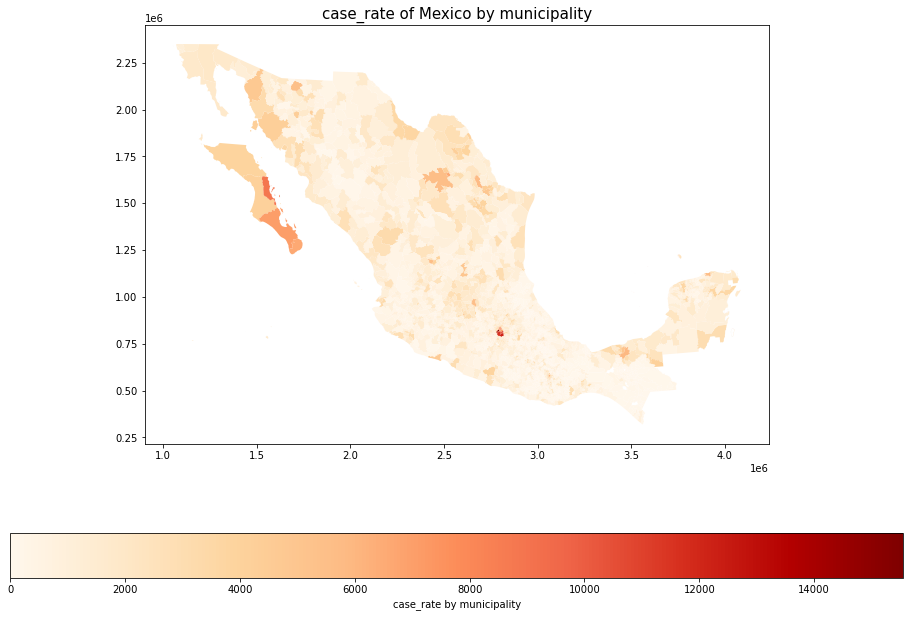

In [16]:
title = '{} of Mexico by municipality'.format(var_widget)
ax1 = df_admin2.plot(column=var_widget, 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': '{} by municipality'.format(var_widget), 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);

By using the municipality data the state analyzes is corroborated meaning that the assumptions are most likely correct.

## Heatmap of correlation variables with case/death rate

The variables to correlated are selected

In [17]:
df = var_admin2[['case_rate', 'case_rate_last_60_days', 'death_rate',
       'death_rate_last_60_days',var_widget]].copy()

The correlation of the variable selected with the case/death rate can be observed as following

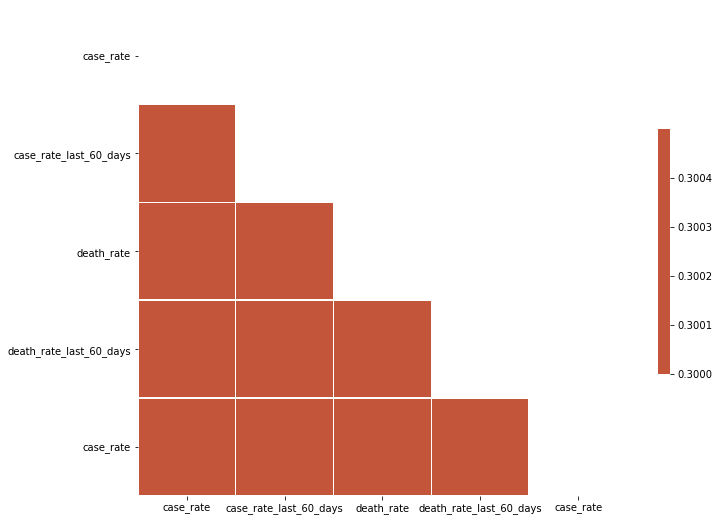

In [18]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.set_context('paper', font_scale=2)
heatmap = heatmap.get_figure()

This correlation can show a direct and more discreate visual representation compared to the Week 3 analyzes but it has the limitation of only using one variable to see is correlation.